# 5. Hybrid model for CSTR 🔆

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/05_Hybrid_CSTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

This Notebook was initially prepared by [Marcus Wenzel](https://www.linkedin.com/in/marcus-wenzel-356a34184/?originalSubdomain=de) and few modifications have been made by us. 

## Goals of this exercise 🌟
- We will build a hybrid model for a reactor 
- We will train the model using sensitivity equations and autodiff

## A quick reminder ✅
**Data-driven models** are also known as black-box models, or machine learning-based, empirical models. **Mechanistic models** are also called white-box models, or knowledge-based, first-principles, or phenomenological models. **Hybrid**, or grey-box models models combine understanding of physical/chemical/biological processes in mechanistic models with modelling unknown phenomena via data-driven approaches [{cite}`glassey2018hybrid, von2014hybrid, mcbride2020hybrid`]. 

Hybrid models aim to balance the advantages and disadvantages of mechanistic and data-driven models. Fundamental knowledge introduces structure to data-driven models, so not all interactions have to be learned by the model. ML-based models introduce a statistical element to knowledge-based models, so not all interactions have to be explained by first-principles.

Advantages of hybrid models include: Lower data requirements, improved understanding of the system, and better extrapolation compared to purely data-driven models; higher estimation/prediction accuracy, more efficient model development compared to purely mechanistic models.

## First-principles model part for CSTR

We model a continuous stirred tank reactor (CSTR) with the following liquid-phase reaction:
$$
A + B \rightleftarrows X
$$

The reactor is fed by a feed of flowrate $F_{in}$ and concentrations $C_{i, in}$ with $i$ denoting species $A$, $B$, and $X$. The reactor has constant volume $V$ and is assumed to be perfectly mixed, with an average residence time $\tau$. The concentrations in the reactor are denoted by $C_{i}$. A stream with constant flowrate $F=F_{in}$ exits the reactor: 

```{figure} media/05_hybrid/CSTR_vars_2.png
:alt: cstr
:width: 40%
:align: center

Schematic representation of the CSTR considered here
```

Let's say we use the following reactor model:

$$
\frac{\mathrm{d}N_A}{\mathrm{d}t} = C_{i,in}F_{in} - C_{i}F - \nu_i rV
$$

$$
\Leftrightarrow \frac{\mathrm{d}C_A}{\mathrm{d}t} = \frac{C_{A,in} - C_A}{\tau} - r
$$

$$
\frac{\mathrm{d}C_B}{\mathrm{d}t} = \frac{C_{B,in} - C_B}{\tau} - r
$$

$$
\frac{\mathrm{d}C_X}{\mathrm{d}t} = \frac{C_{X,in} - C_X}{\tau} + r
$$


The changes in concentration are a result of material added and withdrawn from the reactor as well as created or consumed by the reaction with stochiometric coefficients $\nu_i$ and reaction rate $r$. We assume an average residence time of $\tau= \frac{V}{F} = 100s$. The inlet concentrations of substance $i$ into the reactor are given by


$$
C_{A,in} = 0.7\,\mathrm{kmol/m^3}
$$

$$
C_{B,in} = 0.3\,\mathrm{kmol/m^3}
$$

$$
C_{X,in} = 0\,\mathrm{kmol/m^3}
$$


For solving the differential equation system, we also need to know the initial concentration of each substance inside the reactor, denoted as $C_{i,0}$. From the data it is known that the experiment was started with the following initial concentrations:

$$
C_{A,0} = 0.5\,\mathrm{kmol/m^3}
$$

$$
C_{B,0} = 0.5\,\mathrm{kmol/m^3}
$$

$$
C_{X,0} = 0\,\mathrm{kmol/m^3}
$$


Time-dependent experimental measurements for all concentrations are available:


```{figure} media/05_hybrid/CSTR_experimental.png
:alt: cstr_measurements
:width: 60%
:align: center

CSTR measurements of the concentrations.
```


The task is to construct a **serial hybrid model**, in which the reaction rate $r$ is described by a data-driven model. In this particular example, a **neural network** will be used.

## Serial model construction
### Problem description

The problem with constructing a serial hybrid model, as exemplified above, is that _the data-driven model cannot be trained independently of the differential equation system_ that describes the system (mechanistic part of the hybrid model). The neural network has to learn the function $r=f(C)$ but, of course, we do not have values for $r$ which we could use to train the model. One way to solve this problem is by using **sensitivity equations**. This approach will be discussed in the following.

### Sensitivity equations and solution procedure

We can describe the differential equation system as follows:

$$
\frac{\mathrm{d}y}{\mathrm{d}t} = f(y, u,\phi(y,w))
$$

where $y$ are states of the system, $u$ are system inputs and $\phi(y,w)$ denotes a data-driven model that describes a part of the mechanistic model with the use of the states $y$ and a set of parameter values $w$. In the case of a neural network, the parameter vector $w$ includes all the weights and biases.

In order to train any kind of model, we need a **loss or cost function** (denoted here by $J$) to estimate the quality of our model predictions. Often times, the sum of squares of the deviations between the model predictions and the data is used as an objective for parameter estimation:

$$
J = 0.5 \sum_{i=1}^N\left(y_i - y_{i, \text{exp}}\right)^2,
$$

where $y$ are the set of model predictions corresponding to the $N$ measurement points $y_\text{i,exp}$. The model predictions depend on $u$ and $w$, i.e. $y=f(u,w)$.

Usually, when training a neural network, the gradient of the loss function with respect to the network parameters is used for optimization. The gradient of the loss function with respect to a single parameter $w_j$ is given by

$$
\frac{\partial J}{\partial w_j} = \sum_{i=1}^N\left(y_i - y_{i, \text{exp}}\right)\frac{\partial y}{\partial w_j}.
$$

As can be seen, the gradient depends on $\frac{\partial y}{\partial w_j}$, i.e. the sensitivities of the system states with respect to the parameters (the weights and biases characterizing the neural network). Training of the neural network is then achieved by iteratively updating the parameters according to

$$
w_j^{n+1} = w_j^{n} - g \frac{\partial J}{\partial w_j^{n}},
$$

where $w_j^{n+1}$ is the updated parameter that is calculated from the current parameter $w_j^{n}$ using the gradient $\frac{\partial J}{\partial w_j^{n}}$ and a learning rate (step size) $g$.

The problem could be solved once we have the sensitivities $\frac{\partial y}{\partial w_j}$. Since the mechanistic part of the model is given by a differential equation system, calculating these sensitivities is a bit more complicated than for an algebraic model. Using local sensitivity analysis of the ODE system and denoting the sensitivities $\frac{\partial y}{\partial w_j}$ as $s_j$, the sensitivities can be described by

$$
\frac{\mathrm{d}s_j}{\mathrm{d}t} = \frac{\partial f}{\partial y}s_j + \frac{\partial f}{\partial w_j}.
$$

This equation is a differential equation for the sensitivities. Since $f$ depends on the system states, the differential equations for the sensitivities need to be integrated simultaneously with the ODE system of the mechanistic part.

### Loss function and sensitivity equations for hybrid CSTR model

For the reactor example above, the loss function is defined as

$$
J = 0.5\left[ \sum_{i=1}^N\left(C_{A,i} - C_{A,i,\text{exp}}\right)^2 + \sum_{i=1}^N\left(C_{B,i} - C_{B,i,\text{exp}}\right)^2 + \sum_{i=1}^N\left(C_{X,i} - C_{X,i,\text{exp}}\right)^2\right],
$$

if we assume that we have measurements for all components at each point $i$. Then, the gradient of the loss function with respect to the parameters $w$ is given as 

$$
\frac{\partial J}{\partial w_j} = \sum_{i=1}^N\left(C_{A,i} - C_{A,i,\text{exp}}\right)\frac{\partial C_{A,i}}{\partial w_j} + \sum_{i=1}^N\left(C_{B,i} - C_{B,i,\text{exp}}\right)\frac{\partial C_{B,i}}{\partial w_j} + \sum_{i=1}^N\left(C_{X,i} - C_{X,i,\text{exp}}\right)\frac{\partial C_{X,i}}{\partial w_j},
$$

since the concentrations $C_A$, $C_B$ and $C_X$ are all functions of the parameters of the neural network (weights and biases). The sensitivities are calculated by combining the sensitivity equations with the model definition, according to the following ODE system for each parameter $w_j$, :

$$
\frac{\mathrm{d}}{\mathrm{d}t}\begin{bmatrix}
  \frac{\partial C_{A}}{\partial w_j}\\
  \frac{\partial C_{B}}{\partial w_j}\\
  \frac{\partial C_{X}}{\partial w_j}\\
\end{bmatrix}
=
\begin{bmatrix}
  -\frac{1}{\tau}-\frac{\partial r}{\partial c_A} & -\frac{\partial r}{\partial c_B} & -\frac{\partial r}{\partial c_X}\\
  -\frac{\partial r}{\partial c_A} & -\frac{1}{\tau}-\frac{\partial r}{\partial c_B} & -\frac{\partial r}{\partial c_X} \\
  +\frac{\partial r}{\partial c_A} & +\frac{\partial r}{\partial c_B} & -\frac{1}{\tau}+\frac{\partial r}{\partial c_X} \\
\end{bmatrix}
\begin{bmatrix}
  \frac{\partial c_{A}}{\partial w_j}\\
  \frac{\partial c_{B}}{\partial w_j}\\
  \frac{\partial c_{X}}{\partial w_j}\\
\end{bmatrix}
+
\begin{bmatrix}
  -\frac{\partial r}{\partial w_j}\\
  -\frac{\partial r}{\partial w_j}\\
  +\frac{\partial r}{\partial w_j}\\
\end{bmatrix}
$$

Hence, for $p$ parameters and $l$ system states, there are $p*l$ sensitivity equations to be integrated additionally to the $l$ system equations. If a neural network with 3 input nodes, 10 hidden nodes and 1 output node is used, the total number of parameters is $3*10+10+10*1+1=51$ parameters for three states ($C_A$, $C_B$ and $C_X$). Thus, there would be $3*51=153$ sensitivity equations to be integrated, which quickly becomes computationally intensive.

## Differentiation & autograd
In order to train and run the model, we will need to compute derivates. Automatic differentiation (autodiff) is an algorithm for the fast calculation of accurate derivatives. We will use autograd, the implementation of autodiff in the pytorch package.

Let's see how it works:

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install autograd

In [2]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt

Let's define a function and differentiate it with autograd:

In [3]:
def ex_function(x):
    y = -1.*x*x*x + 3.*x*x - 10.*x + 4.
    #y = np.tanh(x)
    return y

ex_deriv = autograd.grad(ex_function)

input = 3.
print("value of the function: " + str(ex_function(input)))
print("value of the derivative: " + str(ex_deriv(input)))

value of the function: -26.0
value of the derivative: -19.0


Note: Autograd required inputs to be `float` (`int` will not work!). 

We can show this for ranges:

Text(0, 0.5, 'f(x)')

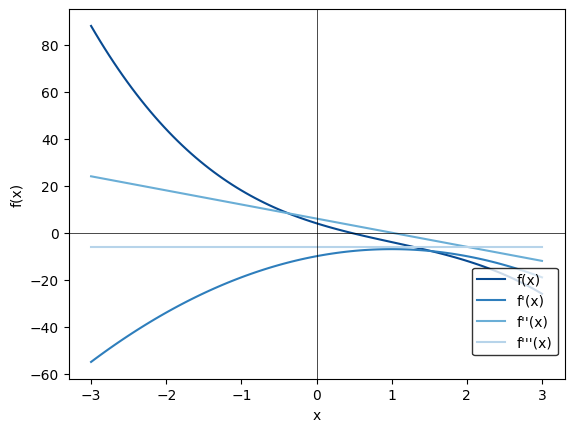

In [4]:
deriv1 = autograd.grad(ex_function)
deriv2 = autograd.grad(deriv1)
deriv3 = autograd.grad(deriv2)

x = np.linspace(-3,3,100, dtype=float)
y = list()
y1 = list()
y2 = list()
y3 = list()

for i in range(len(x)):
    y.append(ex_function(x[i]))
    y1.append(deriv1(x[i]))
    y2.append(deriv2(x[i]))
    y3.append(deriv3(x[i]))

f, ax = plt.subplots(1)
ax.plot(x,y, label = "f(x)", color=plt.get_cmap("Blues")(0.9))
ax.plot(x, y1, label = "f'(x)", color=plt.get_cmap("Blues")(0.7))
ax.plot(x, y2, label = "f''(x)", color=plt.get_cmap("Blues")(0.5))
ax.plot(x, y3, label = "f'''(x)", color=plt.get_cmap("Blues")(0.3))
ax.axhline(0, color="black", linewidth=0.5)
ax.axvline(0, color="black", linewidth=0.5)
#f.legend(loc=(0.75,0.2))
f.legend(loc="center right", bbox_to_anchor=(0.9,0.25), edgecolor="black")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")

### Exercise - autograd ❗❗

Just to practice: implement another function and calculate its derivatives using autograd. Plot them similarly to the above example.

In [5]:
# Your code here

## Implementation

Let's first import the relevant packages:

In [6]:
from autograd import jacobian
from autograd.misc.optimizers import adam
from autograd.scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import autograd.numpy as np

Now we build the neural network. The first function generates random numbers in the shape needed to initialize the neural network. The second function is handed the parameters describing the network as well as an input, and returns the prediction of the network.

In [7]:
# initialize random number generator for repeatable results
np.random.seed(0)

def init_random_params(layer_sizes, scale):
    """Build a list of weights and biases, one for each layer in the net.
    layers is a list with the number of nodes in each layer. Minimum number of layers is three (input, hidden 
    and output) scale is a constant factor to scale the random values (down or up) if necessary"""
    params = []
    for idx in range(len(layer_sizes)-1):
        weight_mat_elem = layer_sizes[idx]*layer_sizes[idx+1]
        bias_vec_elem = layer_sizes[idx+1]
        params = np.append(params, np.random.rand(weight_mat_elem+bias_vec_elem))
    return params*scale

def neural_net_predict(params, inputs):
    """Implements a (deep) neural network for regression.
       params is a list of weights and biases.
       inputs is a matrix of input values.
       returns network prediction."""
    # Make sure that params is a vector
    params = params.flatten()
    # set separator value for easier indexing of the parameters and assigning them to weights and biases 
    # for each layer
    sep = 0
    # loop over all layers
    for idx in range(len(layer_sizes)-1):
        # calculate weight matrix
        W = params[sep:sep+layer_sizes[idx]*layer_sizes[idx+1]].reshape(layer_sizes[idx],layer_sizes[idx+1])
        # calculate bias vector
        b = params[sep+layer_sizes[idx]*layer_sizes[idx+1]:sep+layer_sizes[idx]*layer_sizes[idx+1]
                   +layer_sizes[idx+1]]
        # set new separator value
        sep = layer_sizes[idx]*layer_sizes[idx+1]+layer_sizes[idx+1]
        # calculate output as weighted sum of inputs plus bias
        outputs = np.dot(inputs, W) + b
        # apply activation function and assign the result as the input to the next layer 
        # (note that this has no effect on the output layer)
        inputs = 1/(1 + np.exp(-outputs))
    return outputs

Let's now initialized the model parameters:

In [8]:
# system parameters
tau = 100

# inlet concentrations
c_Ain = 0.7
c_Bin = 0.3
c_Xin = 0

# initial conditions for the concentrations in the reactor
c_A0 = 0.5
c_B0 = 0.5
c_X0 = 0

# end time for integration
t_end = 100
n_samples = 30
t_span = np.linspace(0, t_end, n_samples)

Now we implement the mechanistic part of the model:

In [9]:
# define system equations
def dcdt(c, t, params):
    """Mechanistic part of the hybrid model (ODE system describing the time-dependent 
    concentrations in the reactor)"""
    # disassemble input vector
    c_A, c_B, c_X = c
    # calculate reaction rates by neural network prediction
    r = neural_net_predict(params, c)
    #r = 0.08*c_A**0.7*c_B**1.3 # true underlying reaction rate
    # system equations
    dcdt = [(c_Ain-c_A)/tau - r,
            (c_Bin-c_B)/tau - r,
            (c_Xin-c_X)/tau + r]
    return np.array(dcdt)

Now we use the autograd package to calculate the jacobian with respect to the system states and the parameters, which we'll need for the sensitivity equations:

In [10]:
# calculate system jacobian and parameter derivatives by automatic differentiation with autograd
dfdc = autograd.jacobian(dcdt, 0)    # system jacobian
dfdp = autograd.jacobian(dcdt, 2)    # parameter derivatives

We write a function that takes in the system variables $y$ at time $t$ and calculates the sensitivities:

In [11]:
# differential equation system
def DiffEqs(y, t, params):
    """Hybrid model including the ODE system for the concentrations as well as the sensitivities 
    that are used for training the neural network part of the model"""
    # disassemble input vector
    c = y[:3]
    s = y[3:]
    # evaluate system jacobian at current point
    dfdc_eval = dfdc(c, t, params)
    # evaluate parameter derivatives at current point
    dfdp_eval = dfdp(c, t, params) # Shape: (3, 1, 16)
    
    # define sensitivities for all parameters
    dcdp = np.zeros(len(s)) # preallocate memory for sensitivities
    for i in range(len_p):  # loop over all parameters to construct the corresponding sensitivity equations
        dcdp[i*len_c:(i+1)*len_c] = (dfdc_eval @ s[i*len_c:(i+1)*len_c]).flatten() + dfdp_eval[:,0,i] 
        # construct sensitivities (see https://docs.sciml.ai/v4.0/analysis/sensitivity.html#Example-solving-an-
        # ODELocalSensitivityProblem-1)
        # [c1/w1, c2/w1, c3/w1, c1/w2, ...]
    return np.concatenate((dcdt(c, t, params).flatten(), dcdp))

For training the network, the following parameters need to be specified:

In [12]:
# Training parameters
scale = 0.0005
num_epochs = 1000
step_size = 0.001

# set neural network size
layer_sizes = [3, 3, 1] # no. of nodes in input layer, hidden layer(s) and output layer

# initialize parameter vector for neural network or load saved parameters
init_params = init_random_params(layer_sizes, scale)

Now we specify the initial value of the variables:

In [13]:
# assemble initial value vector
c0 = [c_A0, c_B0, c_X0]
len_c = len(c0)
len_p = len(init_params)
s0 = np.zeros((len_p*len_c))
y0 = np.concatenate((c0,s0))

Let's import the training data

In [14]:
if 'google.colab' in str(get_ipython()):
  df = pd.read_csv("https://raw.githubusercontent.com/edgarsmdn/MLCE_book/main/references/CSTR_ODE_data.txt", sep=';')
else:
  df = pd.read_csv("references/CSTR_ODE_data.txt", sep=';')
c_exp = np.array(df)

The following defines the objective function, also known as loss/risk/error function. First, the model is run, then the difference between experimental data and model prediction is calculated as objective value:

In [15]:
def objective(params, iter):
    """Objective function (sum of squared errors between measurements and model predictions)"""
    # calculate hybrid model in forward direction with odeint
    sol = odeint(DiffEqs, y0, t_span, args=(params,))
    # disassemble results
    c_pred = sol[:,:3] # predicted concentrations
    return np.trace((c_pred - c_exp).T @ (c_pred - c_exp))

In order to train the model, we require the gradient of the objective with respect to the parameters:

In [16]:
def objective_grad(params, iter):
    """Function calculates the gradient of the objective function with respect to the network parameters"""
    sol = odeint(DiffEqs, y0, t_span, args=(params,))
    # disassemble results
    c_pred = sol[:,:3] # predicted concentrations
    sens = sol[:,3:]   # sensititvities 16*3=48 -> c1/w1, c2/w1, c3/w1, c1/w2.....
    # calculate gradients of the loss function
    loss_grad = np.zeros(len_p) # set vector size
    for comp_idx in range(len_c):
        # For loop is running for each concentration and all parameters
        loss_grad += sens[:,comp_idx::3].T @ (c_pred[:,comp_idx] - c_exp[:,comp_idx])
    return loss_grad

Finally, the following function allows us to print the status of the model during training:

In [17]:
def summary(params, iter, gradient):
    """Callback function gives informative output during optimization"""
    if iter % 10 == 0:
        print('step {0:5d}: {1:1.3e}'.format(iter, objective(params, iter)))
        np.save('Params', params)

Now let's train the model with adam! Remember, adam is a gradient descent method with an adaptive learning rate. It uses  both the previous gradients (momentum) and their squares (RMSProp) to calculate the next iteration. 

Note: the code will take a few minutes to run.

In [18]:
# Optimize the network parameters
optimized_params = adam(objective_grad, init_params, step_size=step_size, num_iters=num_epochs, callback=summary)

step     0: 4.279e+00
step    10: 4.804e-01
step    20: 5.815e-01
step    30: 4.494e-01
step    40: 3.714e-01
step    50: 3.808e-01
step    60: 3.715e-01
step    70: 3.713e-01
step    80: 3.696e-01
step    90: 3.695e-01
step   100: 3.689e-01
step   110: 3.685e-01
step   120: 3.681e-01
step   130: 3.676e-01
step   140: 3.672e-01
step   150: 3.667e-01
step   160: 3.662e-01
step   170: 3.656e-01
step   180: 3.650e-01
step   190: 3.644e-01
step   200: 3.637e-01
step   210: 3.630e-01
step   220: 3.622e-01
step   230: 3.614e-01
step   240: 3.605e-01
step   250: 3.596e-01
step   260: 3.586e-01
step   270: 3.575e-01
step   280: 3.563e-01
step   290: 3.550e-01
step   300: 3.536e-01
step   310: 3.521e-01
step   320: 3.505e-01
step   330: 3.487e-01
step   340: 3.468e-01
step   350: 3.447e-01
step   360: 3.425e-01
step   370: 3.401e-01
step   380: 3.375e-01
step   390: 3.347e-01
step   400: 3.317e-01
step   410: 3.284e-01
step   420: 3.250e-01
step   430: 3.212e-01
step   440: 3.173e-01
step   450

Let's compare model solutions with the initial parameters vs. the optimized parameters. We need to run the model forward in time, first with the initial parameters, then with the parameters optimized in training:

In [19]:
sol_init = odeint(DiffEqs, y0, t_span, args=(init_params,))
sol_opt = odeint(DiffEqs, y0, t_span, args=(optimized_params,))

Then we plot the trajectories for the three components, for the untrained model vs. the trained model:

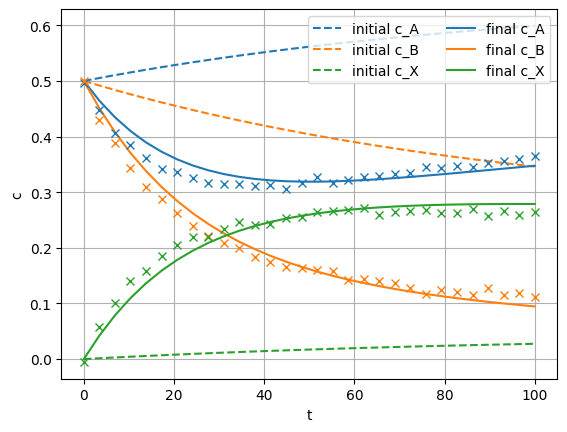

In [20]:
# plot system trajectories
plt.figure(1)
plt.plot(t_span, sol_init[:,:len_c],'--')
plt.gca().set_prop_cycle(None)
plt.plot(t_span, sol_opt[:,:len_c])
plt.gca().set_prop_cycle(None)
plt.plot(t_span, c_exp, 'x')
plt.xlabel('t')
plt.ylabel('c')
plt.legend(('initial c_A', 'initial c_B', 'initial c_X', 
            'final c_A', 'final c_B', 'final c_X'), loc='upper right',ncol=2) # make a legend
plt.grid()
plt.show()

## References

```{bibliography}
:filter: docname in docnames
```